# Importing the Necessary Libraries

For this project, we'll use matplotlib, numpy, pandas, seaborn, tensorflow and tensorflow docs.


In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importing Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# tf version check
print(tf.__version__)

2.1.0


In [2]:
# cleaning the data
def clean_data(data):
    # removing un-needed columns
    cols_to_keep = [
#         "DAY_OF_MONTH",
        "DAY_OF_WEEK",
        "OP_CARRIER",
        "ORIGIN",
#         "DEST",
        "DEP_DEL15",
        "DEP_TIME_BLK",
#         "CANCELLED",
#         "DIVERTED",
#         "DISTANCE"
    ]
    data = data[cols_to_keep]
    
    # removing NA values
    data = data.dropna()
    
    # converting from floats to ints
    data["DEP_DEL15"] = data["DEP_DEL15"].astype(int)
#     data["CANCELLED"] = data["CANCELLED"].astype(int)
#     data["DIVERTED"] = data["DIVERTED"].astype(int)

    # converting categorical variables
    data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].map({
        1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'
    })
    data = pd.get_dummies(data, prefix='', prefix_sep='')

    return data

raw_jan19 = pd.read_csv("../data/Jan_2019_ontime.csv")
raw_jan20 = pd.read_csv("../data/Jan_2020_ontime.csv")

# trim down my data in the dataset
raw_jan19 = raw_jan19.sample(frac=0.5,random_state=0)
raw_jan20 = raw_jan20.sample(frac=0.5,random_state=0)

cleaned_jan19 = clean_data(raw_jan19)
cleaned_jan20 = clean_data(raw_jan20)

cleaned_jan19.head()


,DEP_DEL15,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,9E,AA,...,1400-1459,1500-1559,1600-1659,1700-1759,1800-1859,1900-1959,2000-2059,2100-2159,2200-2259,2300-2359
183878,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
446957,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
52391,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
380221,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
525412,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# separating out the training and testing sets
train_dataset = cleaned_jan19.sample(frac=0.8,random_state=0)
test_dataset = cleaned_jan19.drop(train_dataset.index)

In [4]:
# looking at the overall statistics
train_stats = train_dataset.describe()
train_stats.pop("DEP_DEL15")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Friday,227030.0,0.139237,0.346195,0.0,0.0,0.0,0.0,1.0
Monday,227030.0,0.136145,0.342943,0.0,0.0,0.0,0.0,1.0
Saturday,227030.0,0.105568,0.307284,0.0,0.0,0.0,0.0,1.0
Sunday,227030.0,0.126182,0.332055,0.0,0.0,0.0,0.0,1.0
Thursday,227030.0,0.169793,0.375451,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
1900-1959,227030.0,0.054314,0.226638,0.0,0.0,0.0,0.0,1.0
2000-2059,227030.0,0.044201,0.205542,0.0,0.0,0.0,0.0,1.0
2100-2159,227030.0,0.030216,0.171182,0.0,0.0,0.0,0.0,1.0
2200-2259,227030.0,0.022314,0.147704,0.0,0.0,0.0,0.0,1.0


In [5]:
# separating the target values from the labels
train_labels = train_dataset.pop("DEP_DEL15")
test_labels = test_dataset.pop("DEP_DEL15")

In [6]:
# normalizing the data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
print(normed_train_data.shape)
normed_test_data = norm(test_dataset)

(227030, 389)


In [7]:
# building the model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 29,185
Trainable params: 29,185
Non-trainable params: 0
_________________________________________________________________


In [9]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.8556015 ],
       [-0.22775841],
       [-3.1190472 ],
       [-0.35531545],
       [-0.08003035],
       [-0.39216885],
       [-0.84796023],
       [-0.5879854 ],
       [-0.2109038 ],
       [-0.42420435]], dtype=float32)

In [10]:
EPOCHS = 1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1619,  mae:0.2904,  mse:0.1619,  val_loss:0.1793,  val_mae:0.2757,  val_mse:0.1793,  
.................

Text(0, 0.5, 'MAE [DEP_DEL15]')

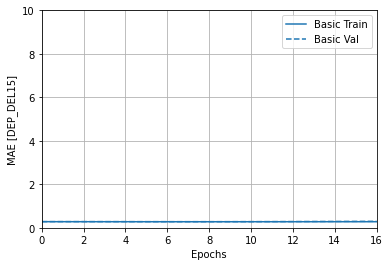

In [11]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [DEP_DEL15]')

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.161854,0.290354,0.161855,0.179315,0.275672,0.179315,0
1,0.147917,0.282180,0.147917,0.142532,0.276165,0.142532,1
2,0.142422,0.278830,0.142422,0.144774,0.315840,0.144774,2
3,0.140544,0.277828,0.140543,0.140537,0.273098,0.140537,3
4,0.140455,0.277614,0.140455,0.141228,0.284078,0.141228,4


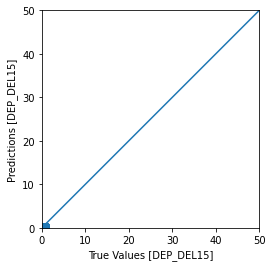

In [13]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DEP_DEL15]')
plt.ylabel('Predictions [DEP_DEL15]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

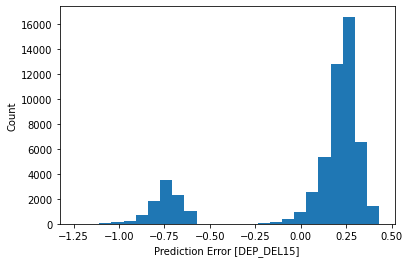

In [14]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [DEP_DEL15]")
_ = plt.ylabel("Count")

In [16]:
test_predictions
test_labels

525412    0
415455    0
24989     0
51038     0
524031    0
         ..
431791    0
437017    0
498674    0
427755    0
229527    0
Name: DEP_DEL15, Length: 56757, dtype: int64